In [5]:
# --- Imports
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Model imports
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# --- Settings
sns.set_theme(style='whitegrid')
np.random.seed(42)

We load in the data and create a meshgrid of points used for predicting the values

In [6]:
# loading a numpy-array containing the topological data
z = np.load('topological_data_Ottadalen.npy')

# --- Generating dataset
n = 5_000 # the square root of the number of datapoints
x, y = np.linspace(0,n,n), np.linspace(0,n,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

z = z.ravel()

## OLS

In [19]:
# --- Creating design matrix
p = 5 # highest polynomial degree
degrees = np.arange(p+1) # for looping
L = [int((d+1)*(d+2)/2) for d in degrees] # beta lengths for plotting later
l = L[-1] # greatest beta length

# --- Loop
MSE_train, MSE_test = np.zeros(p), np.zeros(p)
R2_train, R2_test = np.zeros(p), np.zeros(p)
beta_values = np.zeros((p, l))

for deg in degrees:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    # Splitting the data 
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

    # we use pipeline to fit our model
    pipeline = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler(),
            LinearRegression())

    # fitting our model to our train-dataset and predicting values fro both test and train
    pipeline.fit(X_train, z_train)
    z_tilde = pipeline.predict(X_train)
    z_predict = pipeline.predict(X_test)

    MSE_train[deg-1] = mean_squared_error(z_train, z_tilde)
    MSE_test[deg-1] = mean_squared_error(z_predict, z_test)
    R2_train[deg-1] = r2_score(z_train, z_tilde)
    R2_test[deg-1] = r2_score(z_test, z_predict)

    # retrieving the beta-values
    coefs = pipeline.named_steps['linearregression'].coef_
    beta_values[deg-1, :len(coefs)] = coefs

    print(f'Polynomial degree {deg-1}')


Polynomial degree 0
Polynomial degree 1
Polynomial degree 2
Polynomial degree 3
Polynomial degree 4


In [29]:
df = pd.DataFrame(beta_values, index=list(range(1,6)))
df.insert(21, "MSE_train", MSE_train)
df.insert(22, "MSE_test", MSE_test)
df.insert(23, "R2_train", R2_train)
df.insert(24, "R2_test", R2_test)
df.to_csv('OLS_5_values.csv', index=False)

### Plotting the MSE and R2-score

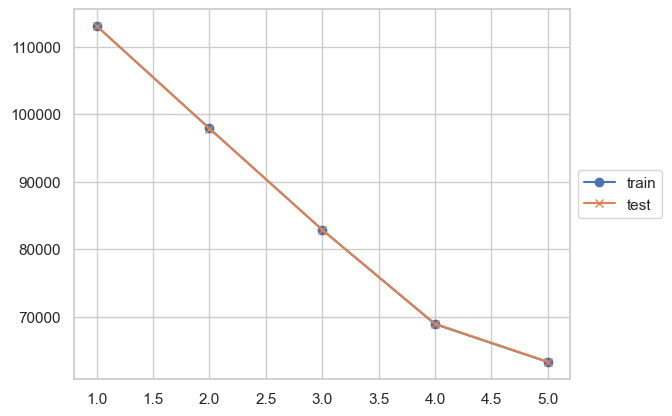

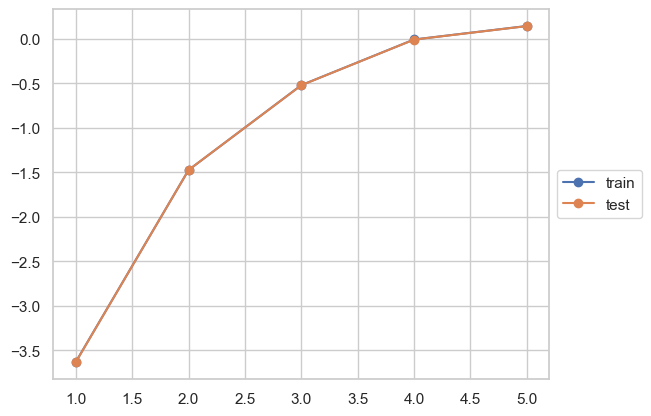

In [4]:
# Plotting MSE and R2 against complexity
plt.plot(N[1:], MSE_train, 'o-', label='train')
plt.plot(N[1:], MSE_test, 'x-', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

plt.plot(N[1:],R2_train, 'o-', label='train')
plt.plot(N[1:],R2_test, 'o-', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

### Plotting the topological data

Using the (currently last fitted model) to predict the entire dataset

In [5]:
z_total = pipeline.predict(X)

x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))

z_orig_plot = z.reshape((n,n))

Plotting the results in a 3D-plot

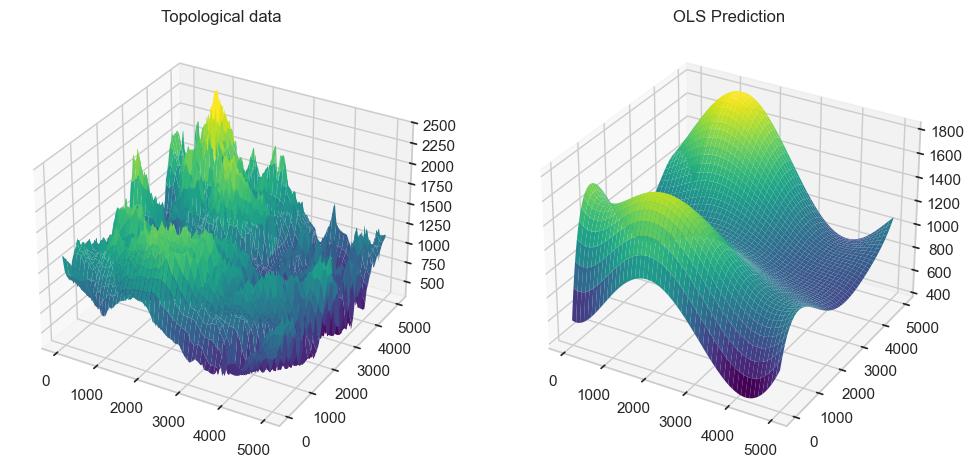

In [6]:
fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Topological data')

# Plot the polynomial regression prediction (ideally a plane)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('OLS Prediction')

plt.show()

Plotting the results as a contour-plot

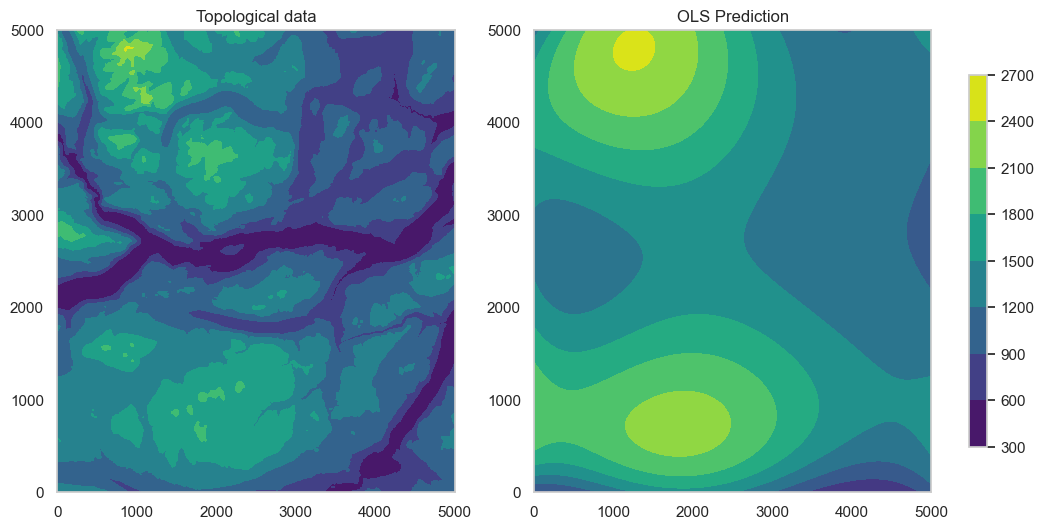

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the datapoints
original_data = axs[0].contourf(x_plot, y_plot, z_orig_plot, cmap='viridis')
axs[0].set_title('Topological data')

# Plot the polynomial regression prediction
fitted_data = axs[1].contourf(x_plot, y_plot, z_plot, cmap='viridis')
axs[1].set_title('OLS Prediction')


# Create the colorbar
contourf_objects = [original_data, fitted_data]
fig.colorbar(contourf_objects[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()

## Ridge

In [8]:
p = 5 # highest polynomial degree 
N = np.arange(p+1) # for looping and plotting later
L = [int((p+1)*(p+2)/2) for p in N] # beta lengths
l = L[-1] # greatest beta length

logmin, logmax, m = -4, 0, 5 # logspce start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

beta_values = np.zeros((p+1, l, m))
MSE_train, MSE_test = np.zeros((p+1, m)), np.zeros((p+1, m))
R2_train, R2_test = np.zeros((p+1, m)), np.zeros((p+1, m))

for i in N:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

    for idx, lmbd in enumerate(llambdas):
        # we use pipeline to fit our model
        pipeline = make_pipeline(
            PolynomialFeatures(degree=i),
            StandardScaler(),
            Lasso(alpha=lmbd, fit_intercept=True, max_iter=56_000))

        pipeline.fit(X_train,z_train)
        z_tilde = pipeline.predict(X_train)
        z_predict = pipeline.predict(X_test)

        MSE_train[i, idx] = mean_squared_error(z_tilde, z_train)
        MSE_test[i, idx] = mean_squared_error(z_predict, z_test)
        R2_train[i, idx] = r2_score(z_train, z_tilde)
        R2_test[i, idx] = r2_score(z_test, z_predict)

        coefs = pipeline.named_steps['lasso'].coef_

        beta_values[i,:len(coefs),idx] = coefs

    print(f'Polynomial degree {i}')


Polynomial degree 0
Polynomial degree 1
Polynomial degree 2


### Testing out stuff

In [2]:
def fitting_data(p: int, x: np.ndarray, y: np.ndarray, z: np.ndarray, regressor=LinearRegression()):
    """ 
    `p`: degree of polynomial  
    """
    N = np.arange(p+1) 
    L = [int((p+1)*(p+2)/2) for p in N] # beta lengths for plotting later
    l = L[-1] # greatest beta length
    beta_values = np.zeros((p+1))

    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    # Splitting the data 
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # we use pipeline to fit our model
    pipeline = make_pipeline(
                PolynomialFeatures(degree=p),
                StandardScaler(),
                regressor)

    # fitting our model to our train-dataset and predicting values fro both test and train
    pipeline.fit(X_train, z_train)
    z_tilde = pipeline.predict(X_train)
    z_predict = pipeline.predict(X_test)

    MSE_train = mean_squared_error(z_tilde, z_train)
    MSE_test = mean_squared_error(z_predict, z_test)
    R2_train = r2_score(z_tilde, z_train)
    R2_test = r2_score(z_predict, z_test)

    coefs = pipeline.named_steps['lasso'].coef_

    beta_values[:len(coefs)+1] = coefs

    return MSE_train, MSE_test, R2_train, R2_test, beta_values